# <center> <b> <h1>   3. SVM Support - 1 -Optimal </h1></b></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn import datasets, svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

import pickle

import pandas as pd
import itertools

PATH_RANKINGS = "../1. SVM RFE (All features)/csv/"
PATH_DATASETS = "../../2_Data_preparation/2_Split_Raw_Datasets/output/"
PATH_MAX_ITER = "../1. SVM RFE (All features)/output/"

In [2]:
def readCsvs(split):
    datasets = []
    constant1 = 'X_'
    constant2 = '_' + split
    features = ['area', 'meancurv', 'thickness', 'volume']

    for feature in features:
        df = pd.read_csv(PATH_DATASETS + constant1 + feature + constant2 +'.csv', index_col=0)
        datasets.append({'name': feature, 'data': df})
    return datasets

In [3]:
def readRankings(ranking = 0):
    datasets = []
    constants = ['used_regions_normalized_convergence_',
                 'used_regions_normalized_highest_']    
    
    features = ['area', 'meancurv', 'thickness', 'volume']

    for feature in features:
        df = pd.read_csv(PATH_RANKINGS + constants[ranking] + feature +'.csv', index_col=0)
        datasets.append({'name': feature, 'data': df})
    return datasets

In [4]:
def readMaxIter(i = 0):
    constants = ['models_info_list_convergence_normalized',
                 'models_info_list_accuracy_normalized',
                 'models_info_list_convergence', 
                 'models_info_list_highest_acc' ]
    
    inputFile = PATH_MAX_ITER + constants[i] +'.data'
    fd = open(inputFile, 'rb')
    data = pickle.load(fd)
    return data

# Prepare The Data

#### convergence

In [5]:
#0 for normalized convergence and 1 for normalized highest accuracy
support_data_convergence = readRankings()
support_data_convergence[0]['data'].head()

,Ranking,Support
Name,,
lh_G_and_S_frontomargin_area,1,True
rh_S_orbital-H_Shaped_area,1,True
lh_S_circular_insula_sup_area,1,True
lh_S_collat_transv_ant_area,1,True
rh_S_collat_transv_post_area,1,True


#### Highest accuracy

In [6]:
#0 for normalized convergence and 1 for normalized highest accuracy
support_data_highest = readRankings(1)
support_data_highest[0]['data'].head()

,Ranking,Support
Name,,
lh_G_and_S_frontomargin_area,1,True
rh_S_orbital-H_Shaped_area,1,True
lh_S_circular_insula_sup_area,1,True
rh_S_circular_insula_ant_area,1,True
rh_G_oc-temp_med-Parahip_area,1,True


In [7]:
df_X_tr = readCsvs('train')
df_X_tr[0]['data'].shape

(550, 148)

In [8]:
df_y_train = pd.read_csv(PATH_DATASETS + 'Y_train.csv', index_col = 0)
df_y_train.shape

(550, 1)

In [9]:
df_X_val = readCsvs('validate')
df_X_val[0]['data'].shape

(338, 148)

In [10]:
df_y_val = pd.read_csv(PATH_DATASETS + 'Y_validate.csv', index_col = 0)
df_y_val.shape

(338, 1)

# 2. Normalize data

In [11]:
for df_tr, df_val in zip(df_X_tr, df_X_val):
    train = df_tr['data']
    val = df_val['data']
    
    normal_tr = (train - train.mean(axis=0))/train.std()
    normal_val = (val - val.mean(axis=0))/val.std()
    
    df_tr['data'] = normal_tr
    df_val['data'] = normal_val

In [12]:
df_X_tr[0]['data'].head()

,lh_G_and_S_frontomargin_area,lh_G_and_S_occipital_inf_area,lh_G_and_S_paracentral_area,lh_G_and_S_subcentral_area,lh_G_and_S_transv_frontopol_area,lh_G_and_S_cingul-Ant_area,lh_G_and_S_cingul-Mid-Ant_area,lh_G_and_S_cingul-Mid-Post_area,lh_G_cingul-Post-dorsal_area,lh_G_cingul-Post-ventral_area,...,rh_S_parieto_occipital_area,rh_S_pericallosal_area,rh_S_postcentral_area,rh_S_precentral-inf-part_area,rh_S_precentral-sup-part_area,rh_S_suborbital_area,rh_S_subparietal_area,rh_S_temporal_inf_area,rh_S_temporal_sup_area,rh_S_temporal_transverse_area
414229,0.309576,0.224009,1.107822,1.264846,-0.053643,0.447702,0.977805,0.781809,-0.594180,-0.761092,...,0.221416,0.381852,-0.114597,1.444931,0.064915,-0.435619,-1.510187,-0.718114,-1.077114,-0.575371
541943,-0.076249,0.352958,-0.262869,0.412671,-0.728809,-0.994397,-0.892543,-0.132296,-1.093925,-0.695517,...,0.137165,3.971853,-0.980071,-0.602848,-1.391463,1.763449,-0.070073,1.569996,-1.101390,-0.732631
206525,1.821379,1.235757,0.221342,1.378470,0.139262,2.154329,0.479456,0.281038,-0.560107,1.577744,...,2.151850,1.750859,1.175570,-0.649815,1.331331,1.466642,1.690066,1.386581,2.638980,0.660251
146533,1.656025,0.933225,1.614382,-0.344818,0.310732,2.457255,1.002415,0.519500,-0.491960,0.054950,...,1.305682,0.006832,0.956788,-0.161354,2.071697,-0.044374,-0.431244,-0.846505,1.292596,-1.024687
194746,-0.918764,0.273605,-0.657688,-0.067072,-0.621640,-0.772536,-0.486481,0.137961,-0.491960,-0.476934,...,0.016284,0.451031,-0.143553,-0.969194,-0.388072,-1.069706,-0.536396,0.079744,-0.490755,-0.081122


### selecting the regions that are in the ranking 

In [13]:
import copy
def selectRegionsRaking(ranking_list):
    new_df_X_tr = copy.deepcopy(df_X_tr)
    new_df_X_val = copy.deepcopy(df_X_val)
    
    for feature_train, feature_validate, ranking in zip(new_df_X_tr, new_df_X_val, ranking_list):
        data_train = feature_train['data']
        data_validate = feature_validate['data']
        data_ranking = ranking['data']

        feature_train['data'] = data_train[data_ranking.index.values].copy()
        feature_validate['data'] = data_validate[data_ranking.index.values].copy()
    
    return new_df_X_tr, new_df_X_val

In [14]:
df_X_tr_convergence, df_X_val_convergence = selectRegionsRaking(support_data_convergence)
df_X_tr_convergence[0]['data'].shape

(550, 11)

In [15]:
df_X_tr_highest, df_X_val_highest = selectRegionsRaking(support_data_highest)
df_X_tr_highest[0]['data'].shape

(550, 15)

In [16]:
#0 and 1 for normalized convergence and accuracy respectively
#2 and 3 for not normalized
model_info_list_convergence_normalized = readMaxIter(0)
model_info_list_highest_accuracy_normalized = readMaxIter(1)

In [17]:
model_info_list_convergence_normalized[0]['data'][0]

2900

# 2. Grid Search CV

In [18]:
def GridSearch(df_X_tr, df_X_val, model_info_list):
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
    scores = ['precision', 'recall']
    best_configuration = []

    for feature_train, feature_validate, model_info in zip(df_X_tr, df_X_val, model_info_list):

        data_name = feature_train['name']
        data_train = feature_train['data']
        data_validate = feature_validate['data']
        max_iter = model_info['data'][0]

        print("******************************** GRID SEARCH FOR: " + data_name + " ******************************")

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            svc = SVC(C = "scale", kernel = 'linear', max_iter = max_iter, cache_size = 2000)
            clf = GridSearchCV(svc, param_grid, verbose=0, n_jobs=-1, scoring='%s_macro' % score, cv = 5)
            clf.fit(data_train, df_y_train['class'].values)

            if (score == 'precision'):
                best_configuration.append({'name' : data_name, 'data' : clf.best_params_})

            print("Best parameters set found on development set: ", clf.best_params_)
            print("Grid scores on develpment set: ")
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                     %(mean, std * 2, params))

            print("Detailed Classification Report: ")
            print("the model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.")
            y_true, y_pred = df_y_val, clf.predict(data_validate)
            print(classification_report(y_true,y_pred))
            print()
    return best_configuration

In [19]:
best_configuration_convergence = GridSearch(df_X_tr_convergence, 
                                            df_X_val_convergence, 
                                            model_info_list_convergence_normalized)

******************************** GRID SEARCH FOR: area ******************************
# Tuning hyper-parameters for precision

Best parameters set found on development set:  {'C': 0.01}
Grid scores on develpment set: 
0.717 (+/-0.060) for {'C': 0.001}
0.726 (+/-0.049) for {'C': 0.01}
0.725 (+/-0.063) for {'C': 0.1}
0.725 (+/-0.078) for {'C': 1}
0.692 (+/-0.075) for {'C': 10}
0.497 (+/-0.175) for {'C': 100}
0.509 (+/-0.118) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.69      0.76      0.73       173
           1       0.72      0.65      0.68       165

    accuracy                           0.71       338
   macro avg       0.71      0.71      0.71       338
weighted avg       0.71      0.71      0.71       338


# Tuning hyper-parameters for recall

Best parameters set found on development set:  {'C': 0.0

/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=8875).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.649 (+/-0.093) for {'C': 0.001}
0.681 (+/-0.079) for {'C': 0.01}
0.723 (+/-0.039) for {'C': 0.1}
0.732 (+/-0.058) for {'C': 1}
0.591 (+/-0.112) for {'C': 10}
0.570 (+/-0.096) for {'C': 100}
0.570 (+/-0.096) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.66      0.62      0.64       173
           1       0.62      0.66      0.64       165

    accuracy                           0.64       338
   macro avg       0.64      0.64      0.64       338
weighted avg       0.64      0.64      0.64       338


# Tuning hyper-parameters for recall



/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=8875).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.645 (+/-0.095) for {'C': 0.001}
0.678 (+/-0.078) for {'C': 0.01}
0.722 (+/-0.041) for {'C': 0.1}
0.731 (+/-0.058) for {'C': 1}
0.589 (+/-0.111) for {'C': 10}
0.569 (+/-0.096) for {'C': 100}
0.569 (+/-0.096) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.66      0.62      0.64       173
           1       0.62      0.66      0.64       165

    accuracy                           0.64       338
   macro avg       0.64      0.64      0.64       338
weighted avg       0.64      0.64      0.64       338


******************************** GRID SEARCH FOR: thickness ******************************
# Tuning hyper-parameters for precision

Best parameters set found on development set:  {'C': 0.01}
Grid scores on develpment set: 
0

/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=4850).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.708 (+/-0.099) for {'C': 0.001}
0.716 (+/-0.072) for {'C': 0.01}
0.744 (+/-0.037) for {'C': 0.1}
0.749 (+/-0.050) for {'C': 1}
0.684 (+/-0.125) for {'C': 10}
0.498 (+/-0.203) for {'C': 100}
0.498 (+/-0.203) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.71      0.75      0.73       173
           1       0.72      0.68      0.70       165

    accuracy                           0.71       338
   macro avg       0.71      0.71      0.71       338
weighted avg       0.71      0.71      0.71       338


# Tuning hyper-parameters for recall

Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.704 (+/-0.099) for {'C': 0.001}
0.713 (+/-0.069) for {'C': 0.01}
0.742 (+/-0.034) for {'C': 0.1}

/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=4850).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [20]:
best_configuration_convergence

[{'name': 'area', 'data': {'C': 0.01}},
 {'name': 'meancurv', 'data': {'C': 1}},
 {'name': 'thickness', 'data': {'C': 0.01}},
 {'name': 'volume', 'data': {'C': 1}}]

In [21]:
best_configuration_highest = GridSearch(df_X_tr_highest, 
                                            df_X_val_highest, 
                                            model_info_list_highest_accuracy_normalized)

******************************** GRID SEARCH FOR: area ******************************
# Tuning hyper-parameters for precision



/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2675).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.723 (+/-0.066) for {'C': 0.001}
0.731 (+/-0.057) for {'C': 0.01}
0.747 (+/-0.080) for {'C': 0.1}
0.748 (+/-0.079) for {'C': 1}
0.684 (+/-0.106) for {'C': 10}
0.481 (+/-0.292) for {'C': 100}
0.481 (+/-0.292) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.69      0.73      0.71       173
           1       0.70      0.65      0.67       165

    accuracy                           0.69       338
   macro avg       0.69      0.69      0.69       338
weighted avg       0.69      0.69      0.69       338


# Tuning hyper-parameters for recall



/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2675).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.718 (+/-0.064) for {'C': 0.001}
0.729 (+/-0.054) for {'C': 0.01}
0.745 (+/-0.079) for {'C': 0.1}
0.747 (+/-0.078) for {'C': 1}
0.682 (+/-0.105) for {'C': 10}
0.482 (+/-0.289) for {'C': 100}
0.482 (+/-0.289) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.69      0.73      0.71       173
           1       0.70      0.65      0.67       165

    accuracy                           0.69       338
   macro avg       0.69      0.69      0.69       338
weighted avg       0.69      0.69      0.69       338


******************************** GRID SEARCH FOR: meancurv ******************************
# Tuning hyper-parameters for precision

Best parameters set found on development set:  {'C': 0.01}
Grid scores on develpment set: 
0.

/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7875).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.647 (+/-0.082) for {'C': 0.001}
0.695 (+/-0.075) for {'C': 0.01}
0.737 (+/-0.032) for {'C': 0.1}
0.751 (+/-0.034) for {'C': 1}
0.595 (+/-0.042) for {'C': 10}
0.579 (+/-0.009) for {'C': 100}
0.579 (+/-0.009) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.68      0.73      0.71       173
           1       0.69      0.65      0.67       165

    accuracy                           0.69       338
   macro avg       0.69      0.69      0.69       338
weighted avg       0.69      0.69      0.69       338


# Tuning hyper-parameters for recall



/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7875).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.644 (+/-0.080) for {'C': 0.001}
0.695 (+/-0.075) for {'C': 0.01}
0.736 (+/-0.030) for {'C': 0.1}
0.751 (+/-0.034) for {'C': 1}
0.593 (+/-0.042) for {'C': 10}
0.578 (+/-0.009) for {'C': 100}
0.578 (+/-0.009) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.68      0.73      0.71       173
           1       0.69      0.65      0.67       165

    accuracy                           0.69       338
   macro avg       0.69      0.69      0.69       338
weighted avg       0.69      0.69      0.69       338


******************************** GRID SEARCH FOR: volume ******************************
# Tuning hyper-parameters for precision



/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7475).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.710 (+/-0.111) for {'C': 0.001}
0.739 (+/-0.107) for {'C': 0.01}
0.765 (+/-0.074) for {'C': 0.1}
0.774 (+/-0.066) for {'C': 1}
0.764 (+/-0.111) for {'C': 10}
0.588 (+/-0.201) for {'C': 100}
0.588 (+/-0.201) for {'C': 1000}
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.71      0.76      0.74       173
           1       0.73      0.67      0.70       165

    accuracy                           0.72       338
   macro avg       0.72      0.72      0.72       338
weighted avg       0.72      0.72      0.72       338


# Tuning hyper-parameters for recall

Best parameters set found on development set:  {'C': 1}
Grid scores on develpment set: 
0.704 (+/-0.109) for {'C': 0.001}
0.735 (+/-0.099) for {'C': 0.01}
0.764 (+/-0.073) for {'C': 0.1}

/home/students/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7475).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [22]:
best_configuration_highest

[{'name': 'area', 'data': {'C': 1}},
 {'name': 'meancurv', 'data': {'C': 0.01}},
 {'name': 'thickness', 'data': {'C': 1}},
 {'name': 'volume', 'data': {'C': 1}}]

In [29]:
clfs = []
for feature, feature_tr, feature_val in zip (best_configuration_convergence, df_X_tr_convergence, df_X_val_convergence):
    c = feature['data']['C']
    data_name = feature_tr['name']
    df_train = feature_tr['data']
    df_val = feature_val['data']
    print(data_name ,df_train.shape)
    
    # create and train
    clf = svm.SVC(kernel='linear', C = c)
    clf.fit(df_train, df_y_train['class'].values)
    
    #checking the score 
    print("Score for train" + data_name + ": ", clf.score(df_train,df_y_train['class'].values))
    #checking the score 
    print("Score val for" + data_name + ": ", clf.score(df_val,df_y_val['class'].values))
    print()
    
    #saving the classificator
    outputFile = "output/SVM (Support - 1 - optimal)" + data_name +'.data'
    fw = open(outputFile, 'wb')
    pickle.dump(clf, fw)
    fw.close()
    #joblib.dump(clf, 'output/SVM (Support - 1 - optimal)' + data_name +'.pkl')
    
    #saving an instance  of the clf 
    clfs.append({'name' : data_name, 'data' : clf})

area (550, 11)
Score for trainarea:  0.7327272727272728
Score val forarea:  0.7071005917159763

meancurv (550, 89)
Score for trainmeancurv:  0.8581818181818182
Score val formeancurv:  0.6301775147928994

thickness (550, 113)
Score for trainthickness:  0.7745454545454545
Score val forthickness:  0.7485207100591716

volume (550, 14)
Score for trainvolume:  0.7545454545454545
Score val forvolume:  0.7071005917159763



In [27]:
for clf in clfs:
    print(clf['data'])

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


# Confusion Matrix

In [27]:
def plot_confusion_matrix(cm, classes, normalize = False,
                         title = 'Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalie = True'
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    # '.2f' limits float to two decimal point
    # 'd' number decimal
    fmt = '.2f' if normalize else 'd' 
    
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format (cm[i,j], fmt), horizontalalignment = "center", verticalalignment = "center",
                 color = "white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[124  49]
 [ 49 116]]
Normalized confusion matrix
[[0.72 0.3 ]
 [0.28 0.7 ]]


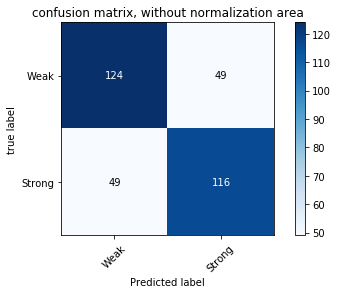

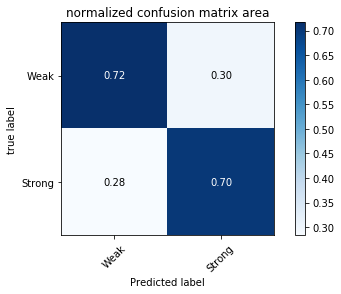

Confusion matrix, without normalization
[[111  62]
 [ 56 109]]
Normalized confusion matrix
[[0.64 0.38]
 [0.32 0.66]]


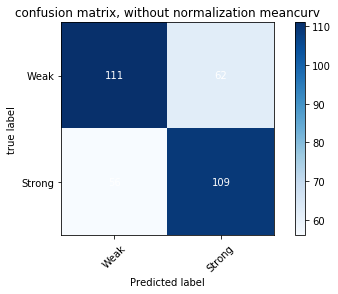

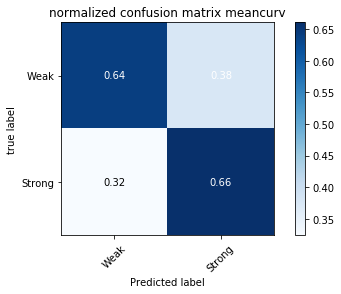

Confusion matrix, without normalization
[[135  38]
 [ 47 118]]
Normalized confusion matrix
[[0.78 0.23]
 [0.27 0.72]]


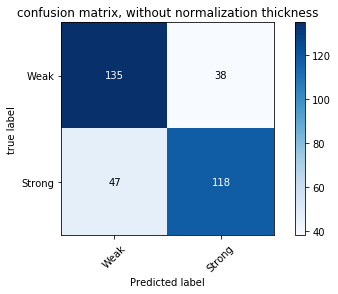

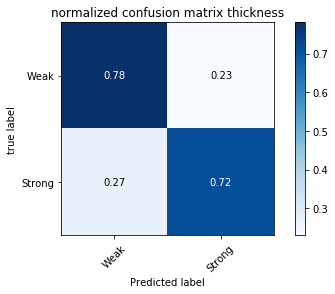

Confusion matrix, without normalization
[[120  53]
 [ 51 114]]
Normalized confusion matrix
[[0.69 0.32]
 [0.29 0.69]]


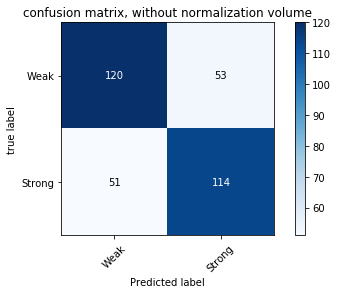

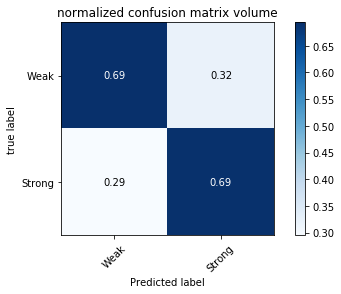

In [28]:
for feature, clf in zip(df_X_val, clfs):
    data = feature['data']
    name = feature['name']
    clf_data = clf['data']
    
    # Compute Confusion matrix
    cnf_matrix = confusion_matrix(df_y_val['class'].values, clf_data.predict(data))
    np.set_printoptions(precision=2)

    # Plot non-normalied confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Weak', 'Strong'],
                         title='confusion matrix, without normalization '+ name)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Weak', 'Strong'], normalize=True,
                         title='normalized confusion matrix '+ name)
    plt.show()
